# SpaCy and Gender Analysis

## [Link to GitHub](https://github.com/Anne-Paris/NLP_NYT_Women-Representation.git) 

## Installs 

In [1]:
!pip install -U spacy

In [2]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install gender-guesser

##Import librairies and data

In [5]:
import spacy
import pandas as pd
nlp = spacy.load("en_core_web_sm")

In [6]:
import gender_guesser.detector as gender

In [7]:
df = pd.read_parquet('gs://nlp_nyt_data_datascience/Project4/nyt_data.parquet')

# Functions toolbox

##Extracting 'Person' type of entity using SpaCy

In [8]:
#Extracts PERSON entities from article/text
def get_named_persons(article):
    doc = nlp(article)
    named_entities = []
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            named_entities.append(ent.text)
    return named_entities

##Looking for feminine pronouns or the words "women" , "woman" "lady", "ladies"

In [9]:
# Define a function to check if a text mentions women
def mentions_women(text):
    doc = nlp(text)
    for token in doc:
        if (token.pos_ == "PRON" and token.lower_ in ["she", "her", "hers", "herself"]) or (token.pos_ == "NOUN" and token.lower_ in ["woman", "women", "lady", "ladies", "dame"]) :
            return True
    return False


##Using Gender detector to classify the first names found at index 0 in array named_entities

In [10]:
def check_for_female_name(sentences):
    detector = gender.Detector()
    for sentence in sentences:
        words = sentence.split()
        if words:
            first_word = words[0]
            if detector.get_gender(first_word) == 'female':
                return True
    return False

def check_for_female_named_entities(row):
    if row['named_entities']:
        return check_for_female_name(row['named_entities'])

## Batch Processing by decades looking at both excerpts and titles

In [11]:
#apply the function by batches:
def process_in_batches(df, batch_size=1000):
    start_idx = 0
    end_idx = batch_size
    while start_idx < len(df):
        # Get a batch of rows
        batch = df.iloc[start_idx:end_idx]
        
        # Apply mentions_women function to the excerpt column
        batch['mentions_women_excerpt'] = batch['excerpt'].apply(mentions_women)
        batch['mentions_women_title'] = batch['title'].apply(mentions_women)
        batch = batch[(batch["mentions_women_excerpt"] == True) | (batch["mentions_women_title"] == True)]
        
        # Increment start_idx and end_idx to move to the next batch
        start_idx += batch_size
        end_idx += batch_size
        
        print(f'end index = {end_idx}')
        #return df
        yield batch

Selects 600 rows randomly for one decade, processing in batches not useful but used just in case we decide to increase number of rows to > 1,000.

ONLY LOOKING AT ARTICLES WITH EXCERPTS AND TITLES

In [12]:
import random

#Function to process batches and returns for each decade
def decades_processing(df, df_new, decade=1920):
    #select decade
    df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
    print(f'(decade = {decade})')
    #Only with excerpts
    df_decade = df_decade[df_decade["excerpt"] != '']
    # Select 600 rows randomly for each year, seed=suposedly allows for the same random rows to be selected each time this is ran...
    df_decade = df_decade.groupby('year').apply(lambda x: x.sample(n=min(600, len(x)), random_state=random.seed()))
    print(f'df_decade size = {df_decade.shape[0]}')
    # Process the dataframe in batches
    for batch in process_in_batches(df_decade):
        df_new = df_new.append(batch)
        print(f'df new size = {df_new.shape[0]}')
    return df_new

DO.NOT.USE.

In [13]:
#DO NOT USE UNLESS YOU HAVE A SUPER COMPUTER FROM NASA THANK YOU
#Function to process batches by decades and returns after one decade
def decades_processing_while(df, df_new, decade=1920):
    while decade < 2021:
        #select decade
        df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
        print(f'(decade = {decade})')
        #Only with excerpts
        df_decade = df_decade[df_decade["excerpt"] != '']
        # Process the dataframe in batches
        for batch in process_in_batches(df_decade):
            df_new = df_new.append(batch)
            print(f'df new size = {df_new.shape[0]}')
        decade += 10
    return df_new

## Auto-decade processing (starts at 1920, ends at 2009 included)

Selects 600 rows randomly for one decade, processing in batches not useful but used just in case we decide to increase number of rows to > 1,000

In [14]:
def decades_processing_while_600rows_stops2010(df, df_new, decade=1920):
    while decade < 2010:
        #select decade
        df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
        print(f'(decade = {decade})')
        #Only with excerpts
        df_decade = df_decade[df_decade["excerpt"] != '']
        # Select 600 rows randomly for each year, seed=suposedly allows for the same random rows to be selected each time this is ran...
        df_decade = df_decade.groupby('year').apply(lambda x: x.sample(n=min(600, len(x)), random_state=random.seed()))
        # Process the dataframe in batches
        for batch in process_in_batches(df_decade):
            df_new = df_new.append(batch)
            print(f'df new size = {df_new.shape[0]}')
        decade += 10
    return df_new

Before using any of the batch processing function, need to create a new empty df to keep appending results

In [15]:
# Create the new DataFrame with the same columns as the original DataFrame
df_new = pd.DataFrame(columns=df.columns)

# Run analysis

In [16]:
df_women = decades_processing_while_600rows_stops2010(df, df_new, decade=1920)

(decade = 1920)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


end index = 2000
df new size = 58
end index = 3000
df new size = 124
end index = 4000
df new size = 164
end index = 5000
df new size = 216
end index = 6000
df new size = 264
end index = 7000
df new size = 294
(decade = 1930)
end index = 2000
df new size = 337
end index = 3000
df new size = 371
end index = 4000
df new size = 418
end index = 5000
df new size = 467
end index = 6000
df new size = 509
end index = 7000
df new size = 540
(decade = 1940)
end index = 2000
df new size = 582
end index = 3000
df new size = 621
end index = 4000
df new size = 651
end index = 5000
df new size = 675
end index = 6000
df new size = 698
end index = 7000
df new size = 724
(decade = 1950)
end index = 2000
df new size = 750
end index = 3000
df new size = 769
end index = 4000
df new size = 792
end index = 5000
df new size = 818
end index = 6000
df new size = 849
end index = 7000
df new size = 867
(decade = 1960)
end index = 2000
df new size = 894
end index = 3000
df new size = 910
end index = 4000
df new siz

Last decade = 2010 to 2020 included, so created a specific function for this decade.

In [17]:
def decades_processing_2010(df, df_new, decade=2010):
    #select decade
    df_decade = df[(df['year'] >= decade) & (df['year'] <= (decade + 10))]
    print(f'(decade = {decade})')
    #Only with excerpts
    df_decade = df_decade[df_decade["excerpt"] != '']
    # Select 600 rows randomly for each year, seed=suposedly allows for the same random rows to be selected each time this is ran...
    df_decade = df_decade.groupby('year').apply(lambda x: x.sample(n=min(600, len(x)), random_state=random.seed()))
    print(f'df_decade size = {df_decade.shape[0]}')
    # Process the dataframe in batches
    for batch in process_in_batches(df_decade):
        df_new = df_new.append(batch)
        print(f'df new size = {df_new.shape[0]}')
    return df_new

df_women_2010_2020 = decades_processing_2010(df, df_new)
df_women_2010_2020.shape[0]

(decade = 2010)
df_decade size = 6515


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


end index = 2000
df new size = 94
end index = 3000
df new size = 156
end index = 4000
df new size = 217
end index = 5000
df new size = 306
end index = 6000
df new size = 420
end index = 7000
df new size = 560
end index = 8000
df new size = 620


620

In [18]:
df_women.tail()

year                                              title  \
(2009, 15875753)  2009  The Ed Hardy brand is a phenomenon that is, in...   
(2009, 15909443)  2009                                    Monologue &#124   
(2009, 15991503)  2009  Thanks to everyone for the interesting to & fr...   
(2009, 15929032)  2009  “None of it feels vintage,” says Betsey Johnso...   
(2009, 16008130)  2009  Go for Broke is a column about purchases worth...   

                                                            excerpt  \
(2009, 15875753)  on the other hand, it diffuses like lead.) Lov...   
(2009, 15909443)  Aired Thursday night on "The Tonight Show With...   
(2009, 15991503)  the late Lynn Manulis of Martha; Ron Herman in...   
(2009, 15929032)  the rosebud prints, a Betsey signature, look l...   
(2009, 16008130)  Marchon.com for stores. Who: Anne Christensen,...   

                 mentions_women_excerpt mentions_women_title  
(2009, 15875753)                   True                False  
(2009, 15909443)                   True                False  
(2009, 15991503)                  False                 True  
(2009, 15929032)                   True                 True  
(2009, 16008130)                   True                False

In [19]:
df_women_2010_2020.tail()

year                                              title  \
(2020, 17316873)  2020  A Christian evangelical who was shunned for he...   
(2020, 17336108)  2020  She was one of a group of black women mathemat...   
(2020, 17351014)  2020  A professor compares the president to a C.E.O....   
(2020, 17335249)  2020  She probed the psychology of mostly upper-clas...   
(2020, 17334604)  2020  She probed the psychology of mostly upper-clas...   

                                                            excerpt  \
(2020, 17316873)             Feminist Found Liberation in the Bible   
(2020, 17336108)               Mathematician Broke Barriers at NASA   
(2020, 17351014)  inspectors general; gap years. Lives Lost to I...   
(2020, 17335249)         Wrote of ‘Preppie Murder’ and Other Crimes   
(2020, 17334604)         Wrote of ‘Preppie Murder’ and Other Crimes   

                 mentions_women_excerpt mentions_women_title  
(2020, 17316873)                  False                 True  
(2020, 17336108)                  False                 True  
(2020, 17351014)                  False                 True  
(2020, 17335249)                  False                 True  
(2020, 17334604)                  False                 True

In [20]:
df_women_100years = df_women.append(df_women_2010_2020)

# Data Visualization: Wordclouds by decade



## Women nouns

In [37]:
from collections import Counter #for counting
import seaborn as sns #for visualization
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud

def get_word_cloud(df, decade):
    df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
    text = df_decade['excerpt'].str.cat(sep=' ')
    # spaCy enforces a max limit of 1000000 characters for NER and similar use cases.
    # Since `text` might be longer than that, we will slice it off here
    max_length = 1000000-1
    text = text[:max_length]
    doc = nlp(text)
    female_topics = []
    for token in doc:
        if (not token.is_stop) and (token.pos_ == "NOUN") and (len(str(token))>2) and (str(token) != 'years') and (str(token) != 'year') and (str(token) != 'Years') and (str(token) != 'Year') and (str(token) != 'Today') and (str(token) != 'today') and (str(token) != 'tonight') and (str(token) != 'Tonight') and (str(token) != 'tomorrow') and (str(token) != 'Tomorrow') and (str(token) != 'Women') and (str(token) != 'women') and (str(token) != 'Woman') and (str(token) != 'woman') and (str(token) != 'yesterday') and (str(token) != 'WOMAN'):
            female_topics.append(token)

    female_topics = [str(x) for x in female_topics]
    plt.figure(figsize=(10,5))
    wordcloud = WordCloud(background_color="white",
                          stopwords = STOP_WORDS,
                          max_words=45,
                          max_font_size=30,
                          random_state=42
                         ).generate(str(female_topics))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f'Decade: {decade}')
    plt.show()

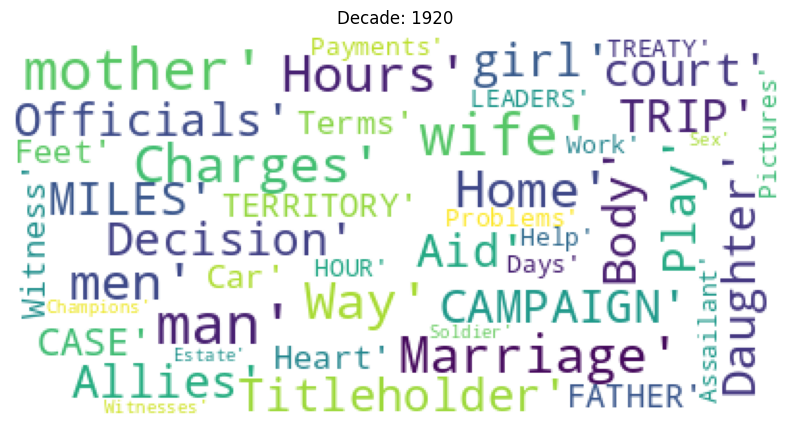

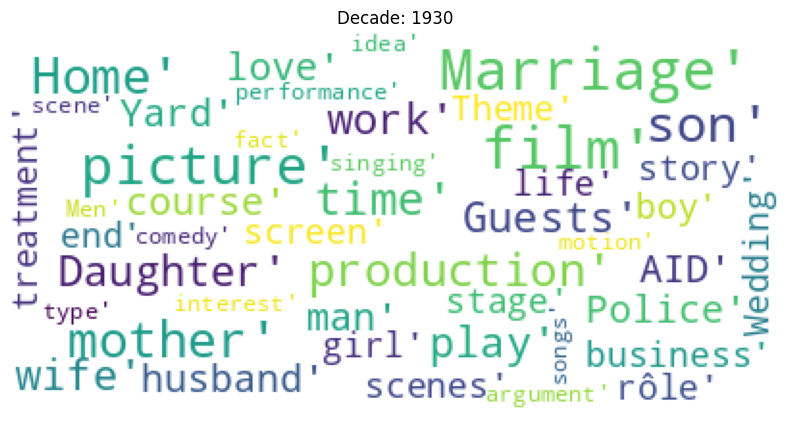

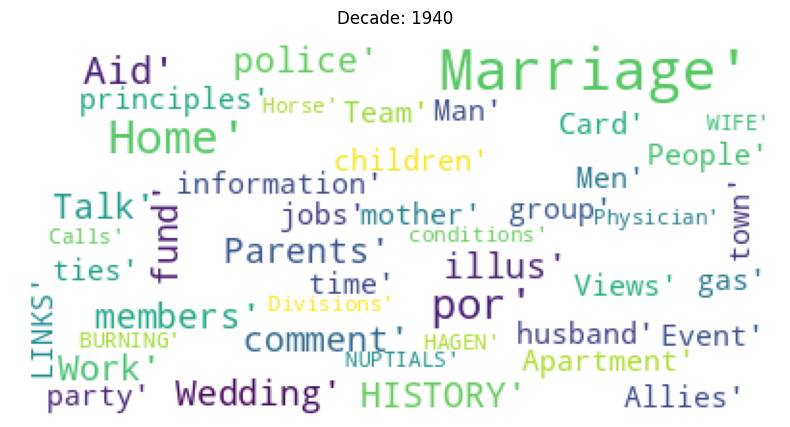

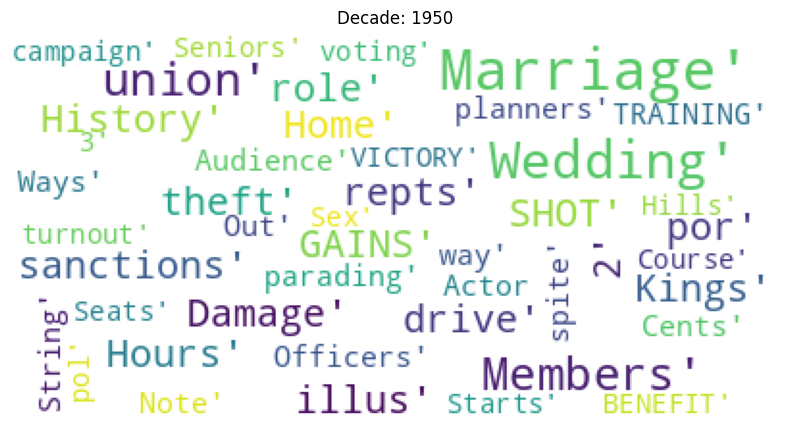

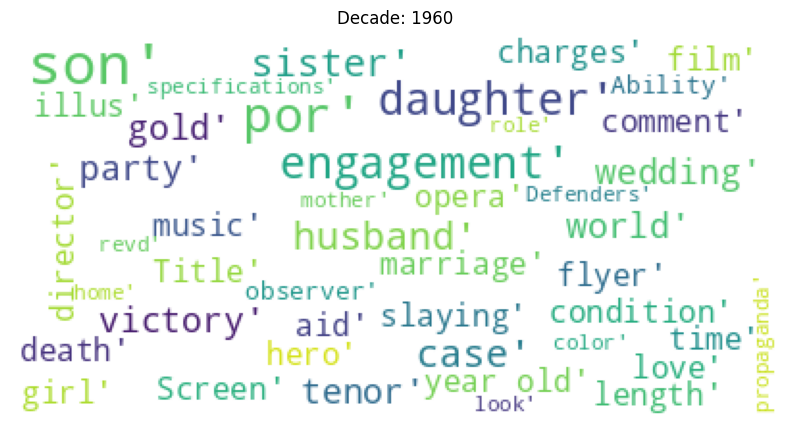

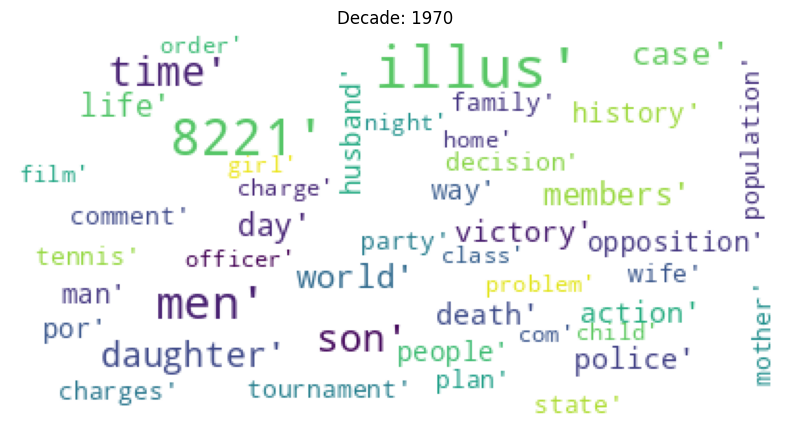

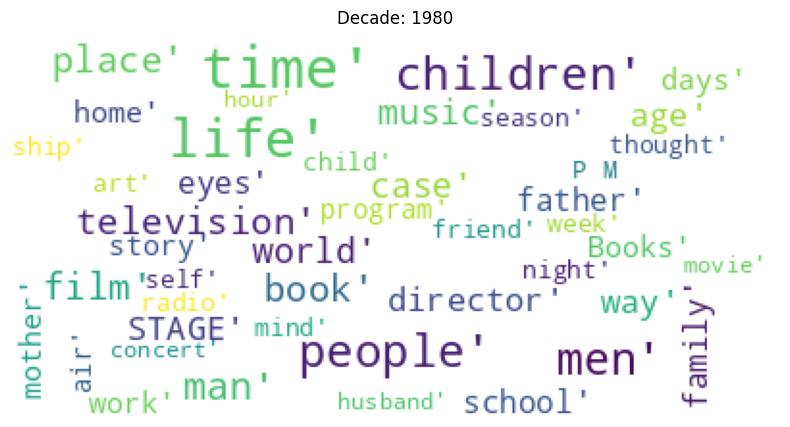

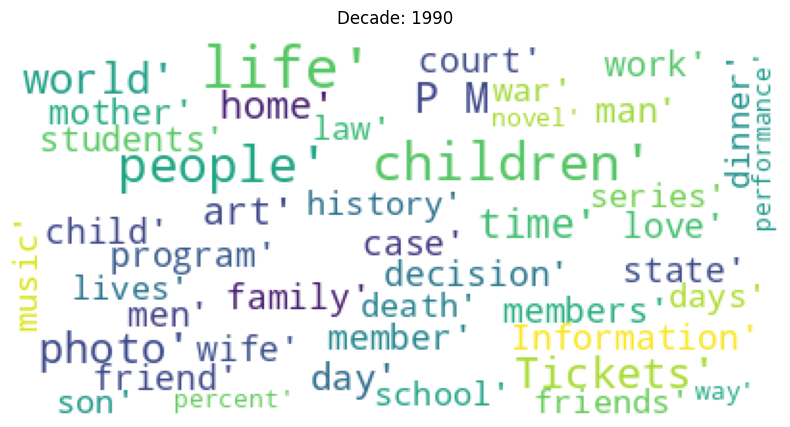

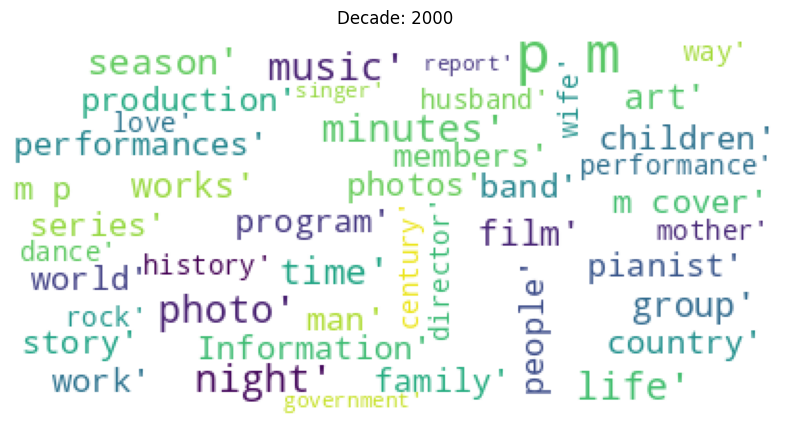

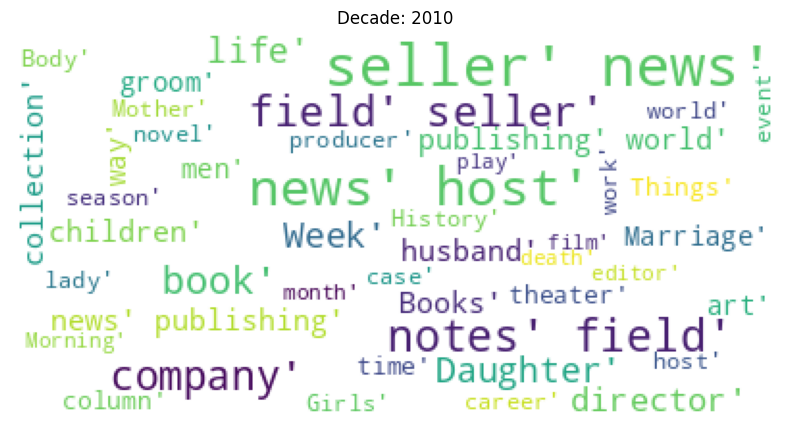

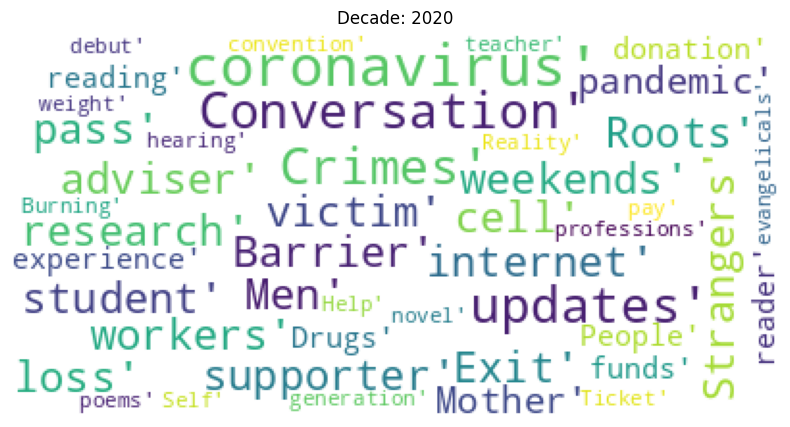

In [38]:
decade = 1920
while decade < 2021:
    get_word_cloud(df_women_100years, decade)
    decade += 10



## Percentage of articles mentioning women

In [23]:
#Calculate the ratio of women mentioned for each year
# Group the DataFrame by year
year_groups = df_women_100years.groupby('year')

# Calculate the number of rows per year
year_rows = year_groups.size()
    
# Calculate the ratio of rows to 600 for each year
women_mentions_percent = year_rows.apply(lambda count: (count / 600)*100)
    
# Create a DataFrame with the year and ratio columns
result_df = pd.DataFrame({'percentage of articles mentioning women': women_mentions_percent})

In [24]:
result_df

percentage of articles mentioning women
year                                         
1920                                 5.833333
1921                                 6.666667
1922                                 6.333333
1923                                 5.666667
1924                                 2.833333
...                                       ...
2016                                11.500000
2017                                 9.833333
2018                                10.666667
2019                                15.000000
2020                                12.000000

[101 rows x 1 columns]

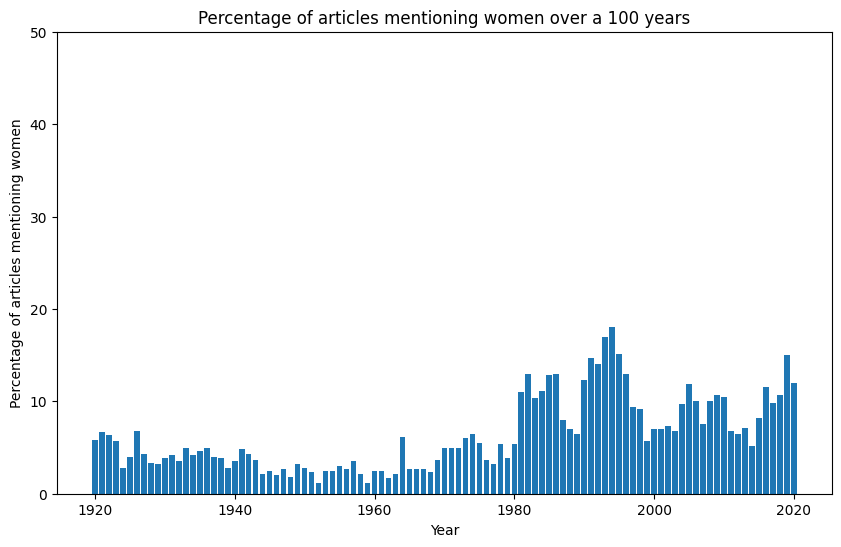

In [25]:
# create a bar graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(result_df.index, result_df['percentage of articles mentioning women'])
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of articles mentioning women')
ax.set_title('Percentage of articles mentioning women over a 100 years')
ax.set_ylim(0, 50)
plt.show()

## Wordclouds for women adjectives

In [26]:
def get_word_cloud_adj(df, decade):
    df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
    text = df_decade['excerpt'].str.cat(sep=' ')
    # spaCy enforces a max limit of 1000000 characters for NER and similar use cases.
    # Since `text` might be longer than that, we will slice it off here
    max_length = 1000000-1
    text = text[:max_length]
    doc = nlp(text)
    female_topics = []
    for token in doc:
        if (not token.is_stop) and (token.pos_ == "ADJ") and (len(str(token))>2):
            female_topics.append(token)

    female_topics = [str(x) for x in female_topics]
    plt.figure(figsize=(10,5))
    wordcloud = WordCloud(background_color="white",
                          stopwords = STOP_WORDS,
                          max_words=45,
                          max_font_size=30,
                          random_state=42
                         ).generate(str(female_topics))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f'Decade: {decade}')
    plt.show()

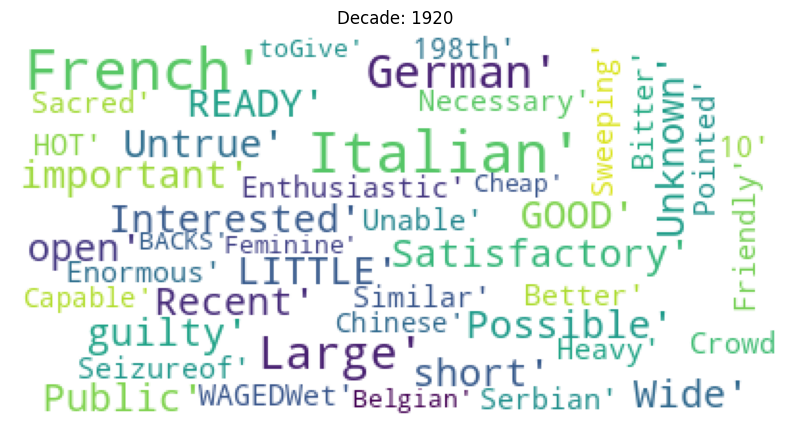

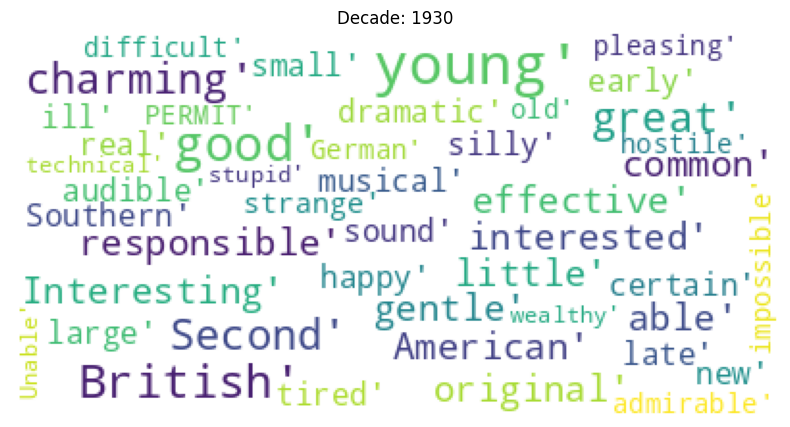

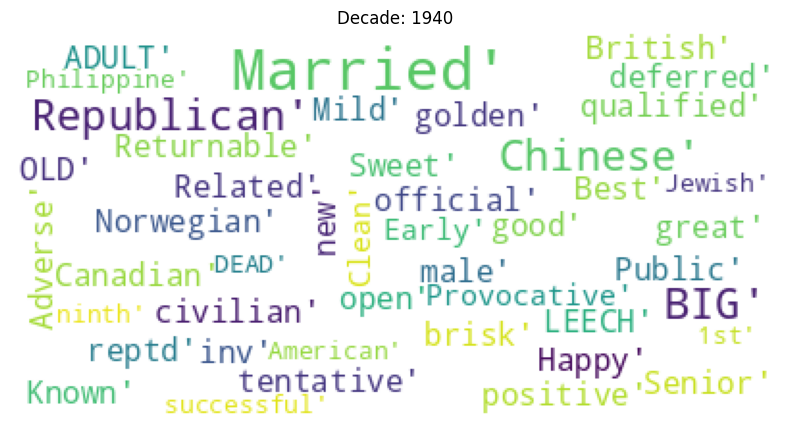

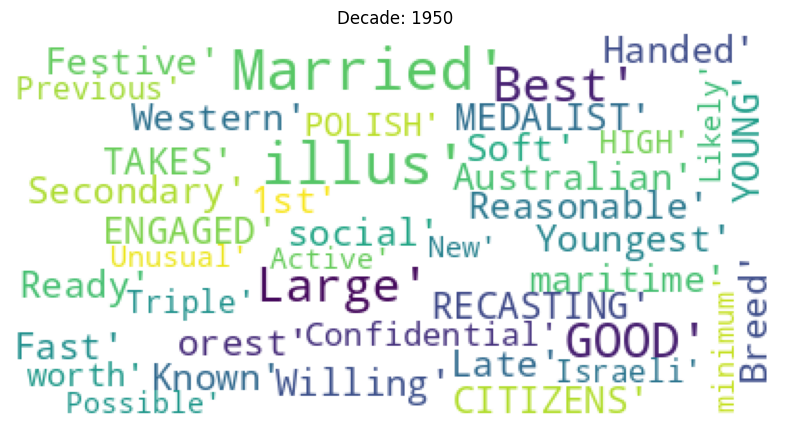

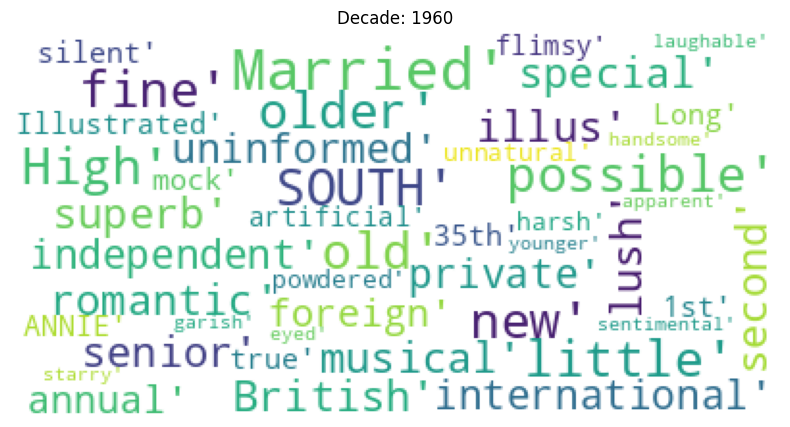

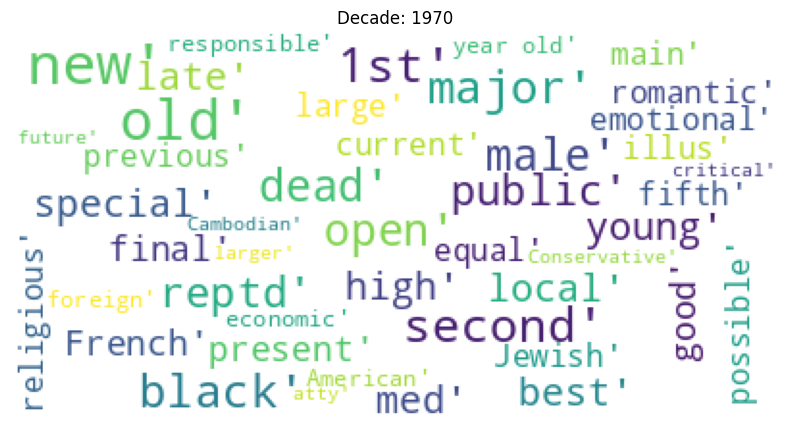

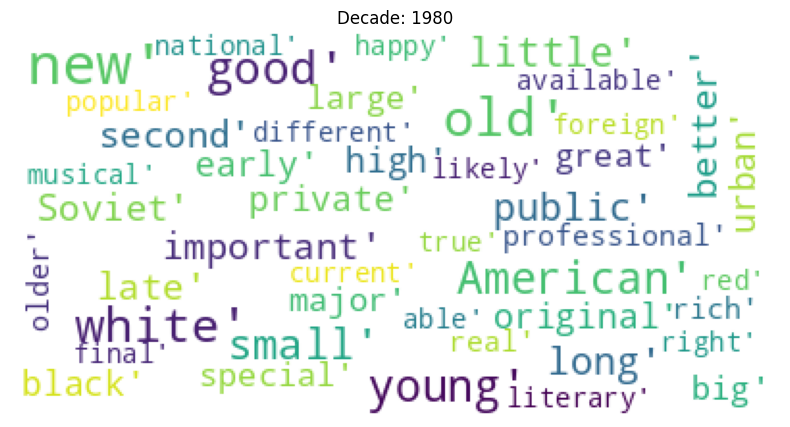

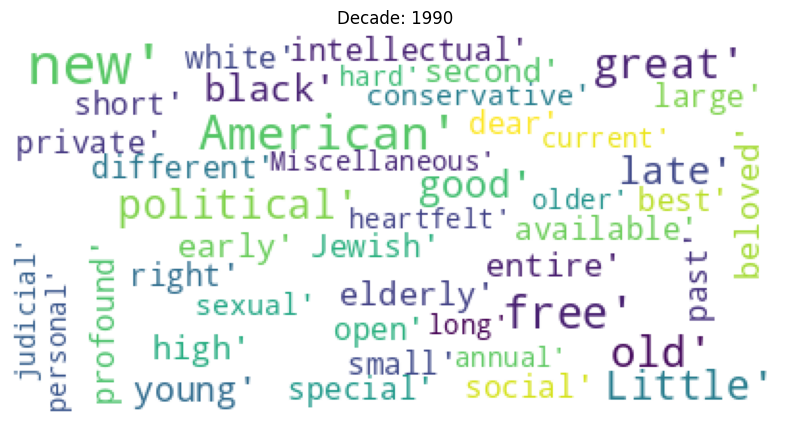

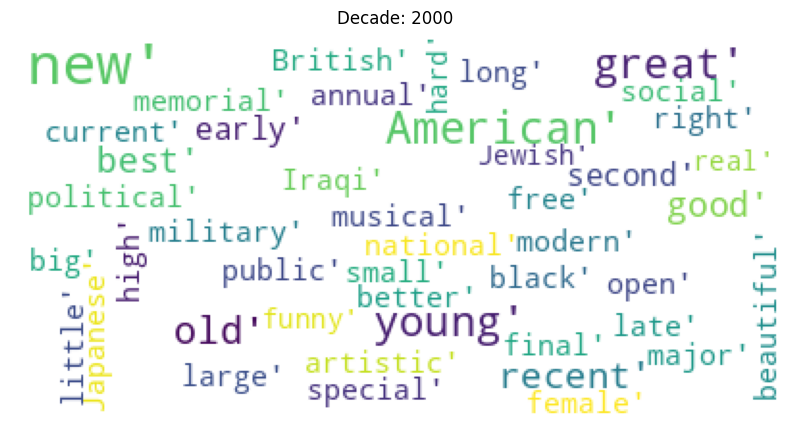

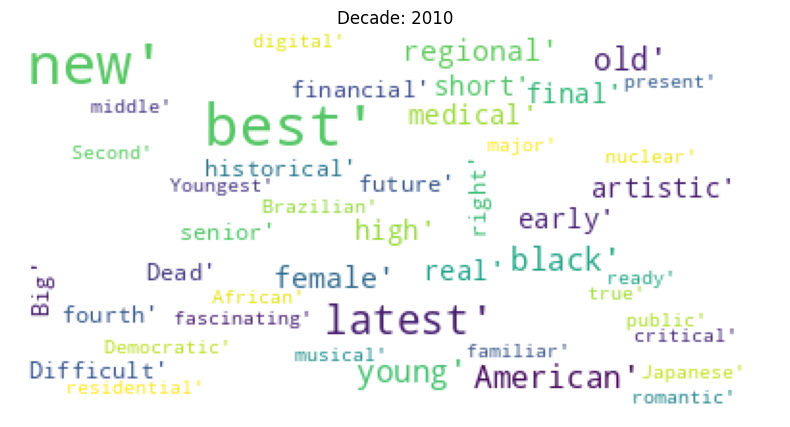

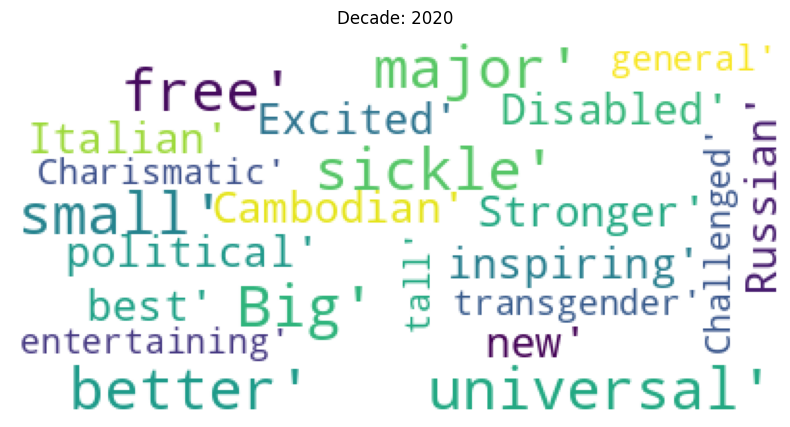

In [27]:
decade = 1920
while decade < 2021:
    get_word_cloud_adj(df_women_100years, decade)
    decade += 10


# Men analysis

## Functions to extract mentions of men

In [28]:
# Define a function to check if a text mentions men
def mentions_men(text):
    doc = nlp(text)
    for token in doc:
        if (token.pos_ == "PRON" and token.lower_ in ["he", "him", "his", "himself"]) or (token.pos_ == "NOUN" and token.lower_ in ["men", "man", "gentleman", "gentlemen"]):
            return True
    return False

## Function to batch process

In [29]:
#apply the function mentions_men by batches:
def process_in_batches_men(df, batch_size=1000):
    start_idx = 0
    end_idx = batch_size
    while start_idx < len(df):
        # Get a batch of rows
        batch = df.iloc[start_idx:end_idx]
        
        # Apply mentions_women function to the excerpt column
        batch['mentions_men_excerpt'] = batch['excerpt'].apply(mentions_men)
        batch['mentions_men_title'] = batch['title'].apply(mentions_men)
        batch = batch[(batch["mentions_men_excerpt"] == True) | (batch["mentions_men_title"] == True)]
        
        # Increment start_idx and end_idx to move to the next batch
        start_idx += batch_size
        end_idx += batch_size
        
        #return df
        yield batch

In [30]:
#takes in df, selects 600 rows every year and processes batches per decades per 1,000 rows
def decades_processing_while_600rows_stops2010_men(df, df_new, decade=1920):
    while decade < 2010:
        #select decade
        df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
        print(f'(decade = {decade})')
        #Only with excerpts
        df_decade = df_decade[df_decade["excerpt"] != '']
        # Select 600 rows randomly for each year, seed=suposedly allows for the same random rows to be selected each time this is ran...
        df_decade = df_decade.groupby('year').apply(lambda x: x.sample(n=min(600, len(x)), random_state=random.seed()))
        # Process the dataframe in batches
        for batch in process_in_batches_men(df_decade):
            df_new = df_new.append(batch)
            print(f'df new size = {df_new.shape[0]}')
        decade += 10
    return df_new


In [32]:
# Create the new DataFrame with the same columns as the original DataFrame
df_new = pd.DataFrame(columns=df.columns)

df_men = decades_processing_while_600rows_stops2010_men(df, df_new, decade=1920)

(decade = 1920)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


df new size = 196
df new size = 380
df new size = 516
df new size = 704
df new size = 855
df new size = 991
(decade = 1930)
df new size = 1136
df new size = 1293
df new size = 1411
df new size = 1525
df new size = 1630
df new size = 1745
(decade = 1940)
df new size = 1854
df new size = 1949
df new size = 2037
df new size = 2112
df new size = 2185
df new size = 2283
(decade = 1950)
df new size = 2365
df new size = 2467
df new size = 2558
df new size = 2643
df new size = 2749
df new size = 2853
(decade = 1960)
df new size = 2953
df new size = 3067
df new size = 3208
df new size = 3350
df new size = 3491
df new size = 3652
(decade = 1970)
df new size = 3825
df new size = 4055
df new size = 4348
df new size = 4571
df new size = 4792
df new size = 4989
(decade = 1980)
df new size = 5269
df new size = 5657
df new size = 6051
df new size = 6416
df new size = 6667
df new size = 6933
(decade = 1990)
df new size = 7286
df new size = 7697
df new size = 8117
df new size = 8442
df new size = 8648
d

In [33]:
def decades_processing_2010_men(df, df_new, decade=2010):
    #select decade
    df_decade = df[(df['year'] >= decade) & (df['year'] <= (decade + 10))]
    print(f'(decade = {decade})')
    #Only with excerpts
    df_decade = df_decade[df_decade["excerpt"] != '']
    # Select 600 rows randomly for each year, seed=suposedly allows for the same random rows to be selected each time this is ran...
    df_decade = df_decade.groupby('year').apply(lambda x: x.sample(n=min(600, len(x)), random_state=random.seed()))
    print(f'df_decade size = {df_decade.shape[0]}')
    # Process the dataframe in batches
    for batch in process_in_batches_men(df_decade):
        df_new = df_new.append(batch)
        print(f'df new size = {df_new.shape[0]}')
    return df_new

df_men_2010_2020 = decades_processing_2010_men(df, df_new)

df_men = df_men.append(df_men_2010_2020)

(decade = 2010)
df_decade size = 6515


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


df new size = 169
df new size = 310
df new size = 422
df new size = 606
df new size = 810
df new size = 1002
df new size = 1101


## Calculate the percentage of articles mentioning men

In [34]:
#Calculate the ratio of men mentioned for each year
# Group the DataFrame by year
year_groups = df_men.groupby('year')

# Calculate the number of rows per year
year_rows = year_groups.size()
    
# Calculate the ratio of rows to 600 for each year
men_mentions_percent = year_rows.apply(lambda count: (count / 600)*100)
    
# Create a DataFrame with the year and ratio columns
result_df_men = pd.DataFrame({'percentage of articles mentioning men': men_mentions_percent})

In [35]:
result_df_men

percentage of articles mentioning men
year                                       
1920                              18.666667
1921                              21.000000
1922                              19.833333
1923                              13.333333
1924                              13.166667
...                                     ...
2016                              18.333333
2017                              19.833333
2018                              16.833333
2019                              19.333333
2020                              20.000000

[101 rows x 1 columns]

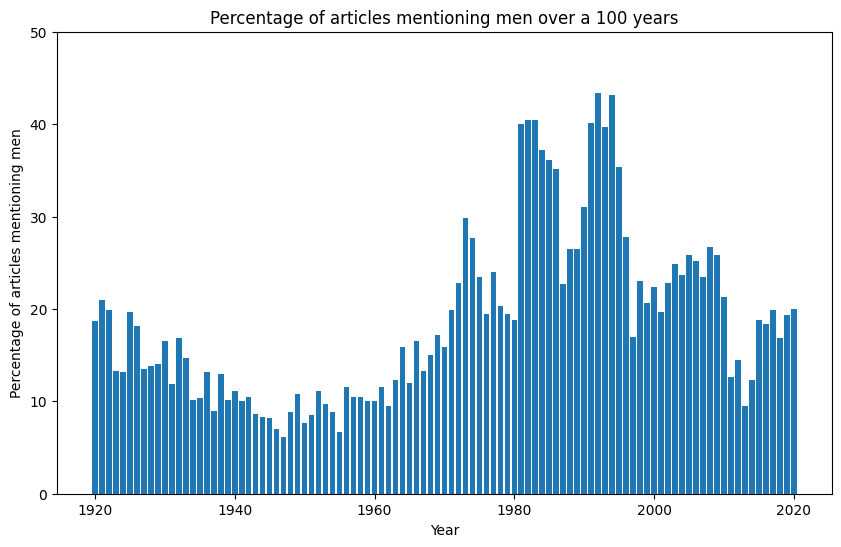

In [36]:
# create a bar graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(result_df.index, result_df_men['percentage of articles mentioning men'])
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of articles mentioning men')
ax.set_title('Percentage of articles mentioning men over a 100 years')
ax.set_ylim(0, 50)
plt.show()

## WordClouds for men

In [39]:
def get_word_cloud_men(df, decade):
    df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
    text = df_decade['excerpt'].str.cat(sep=' ')
    # spaCy enforces a max limit of 1000000 characters for NER and similar use cases.
    # Since `text` might be longer than that, we will slice it off here
    max_length = 1000000-1
    text = text[:max_length]
    doc = nlp(text)
    male_topics = []
    for token in doc:
        if (not token.is_stop) and (token.pos_ == "NOUN") and (len(str(token))>2) and (str(token) != 'years') and (str(token) != 'year') and (str(token) != 'Years') and (str(token) != 'Year') and (str(token) != 'Today') and (str(token) != 'today') and (str(token) != 'tonight') and (str(token) != 'Tonight') and (str(token) != 'tomorrow') and (str(token) != 'Tomorrow') and (str(token) != 'Men') and (str(token) != 'men') and (str(token) != 'man') and (str(token) != 'Man'):
            male_topics.append(token)

    male_topics = [str(x) for x in male_topics]
    plt.figure(figsize=(10,5))
    wordcloud = WordCloud(background_color="white",
                          stopwords = STOP_WORDS,
                          max_words=45,
                          max_font_size=30,
                          random_state=42
                         ).generate(str(male_topics))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f'Decade: {decade}')
    plt.show()

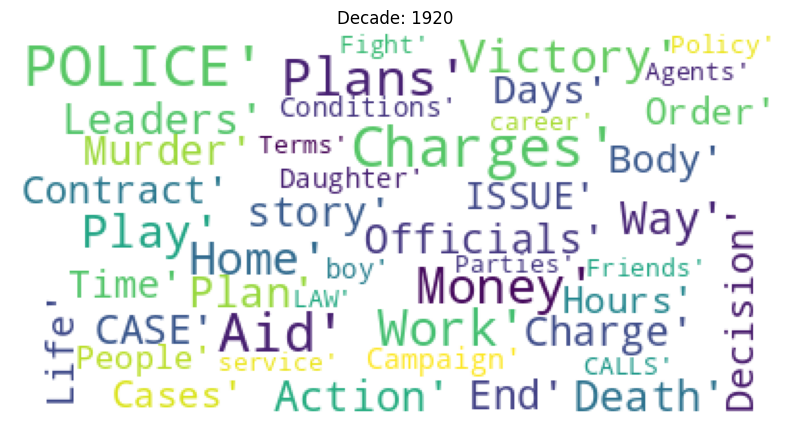

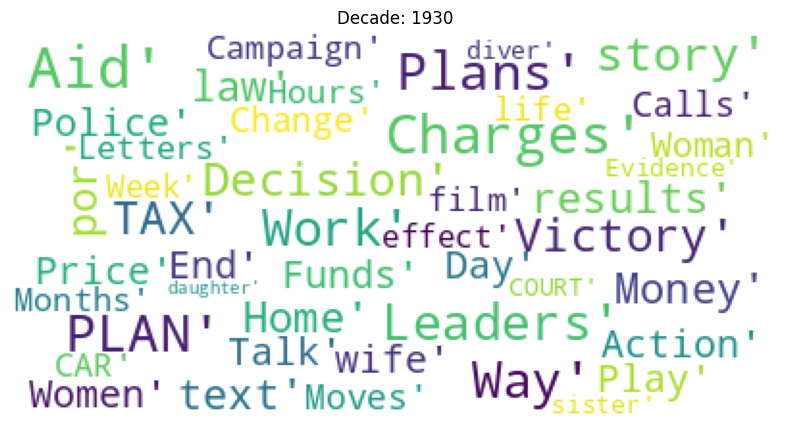

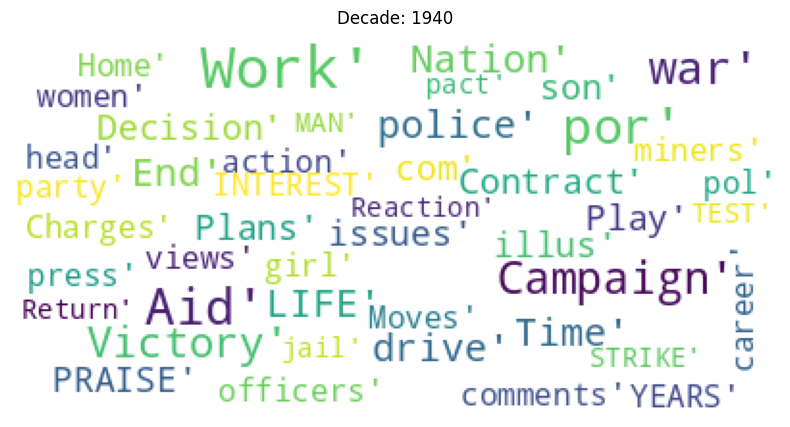

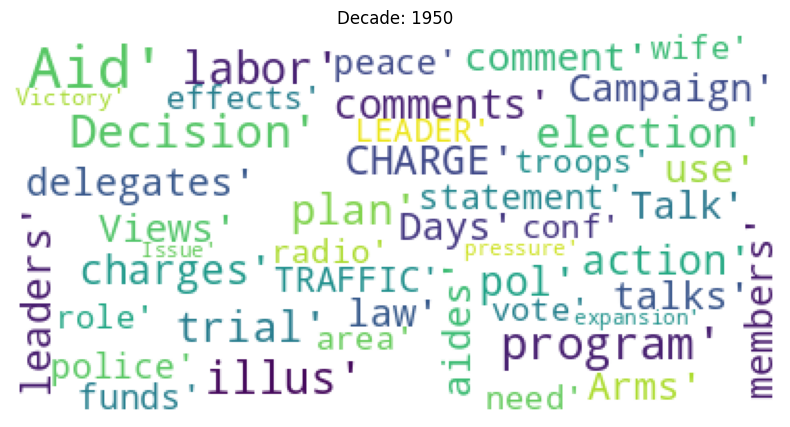

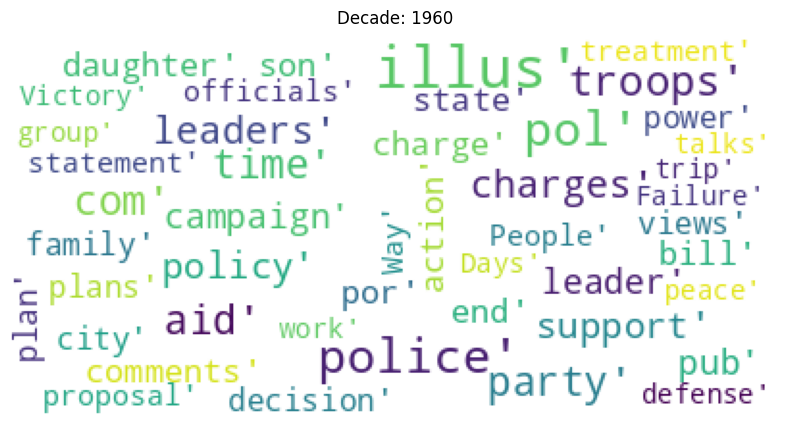

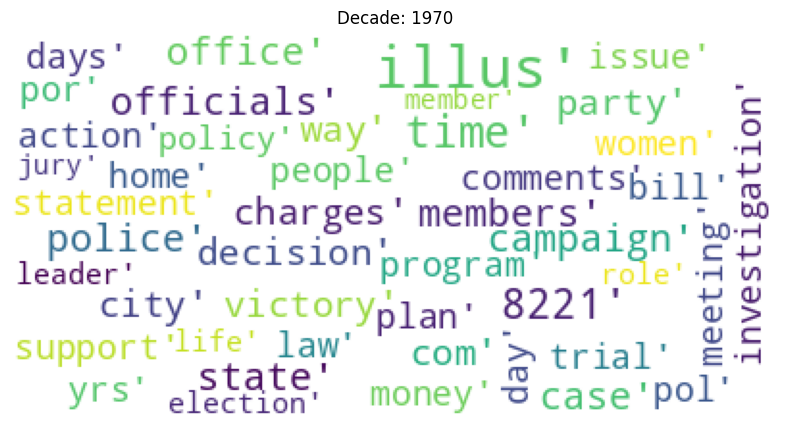

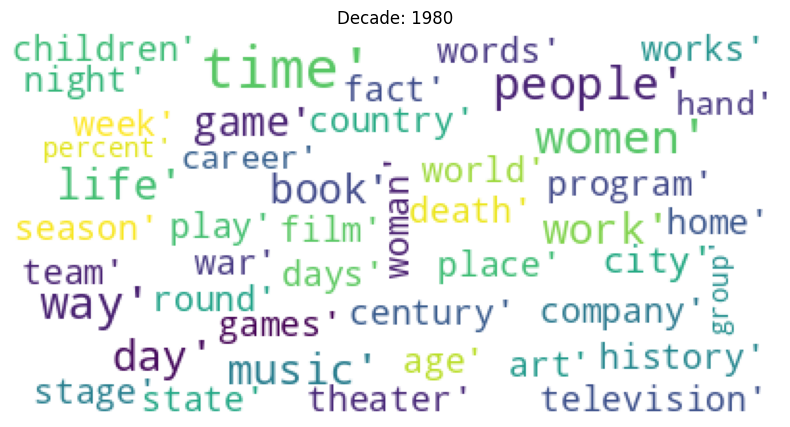

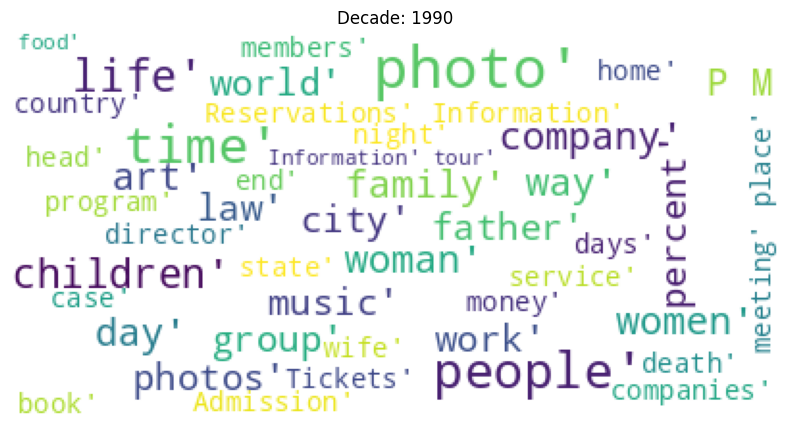

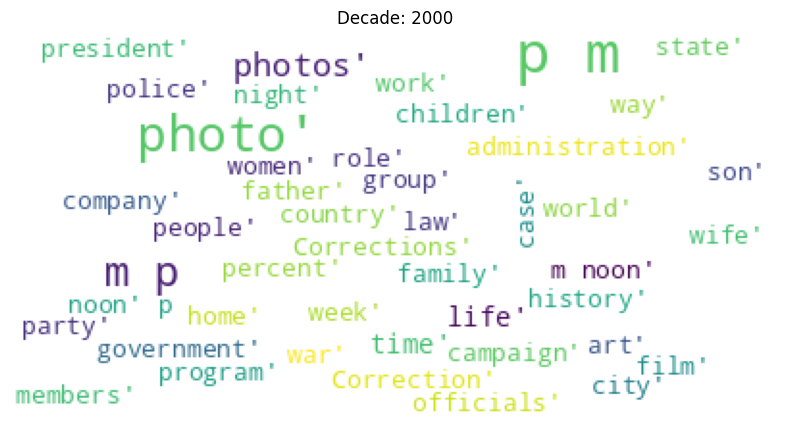

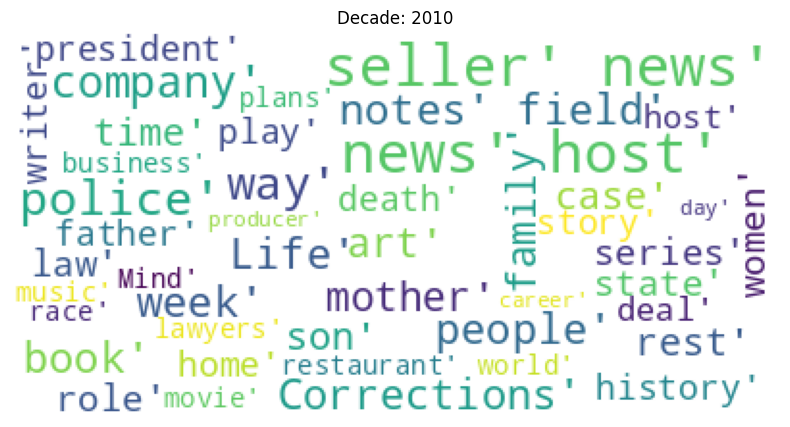

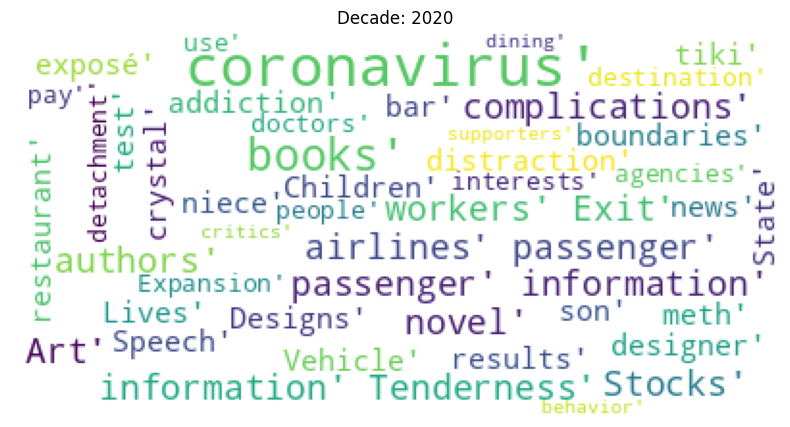

In [40]:
decade = 1920
while decade < 2021:
    get_word_cloud_men(df_men, decade)
    decade += 10